In [1]:
import json
import re
import sys
import pandas as pd
import numpy as np

# TODO: Check whether spacy is allowed
import spacy

In [2]:
# TODO: Load latest multimodal_transformers from GitHub to allow dataframes

In [3]:
from dataclasses import dataclass, field
import json
import logging
import os
from typing import Optional

from transformers import (
    AutoTokenizer,
    AutoConfig,
    Trainer,
    EvalPrediction,
    set_seed
)
from transformers.training_args import TrainingArguments

from multimodal_transformers.data import load_data_from_folder
from multimodal_transformers.model import TabularConfig
from multimodal_transformers.model import AutoModelWithTabular

logging.basicConfig(level=logging.INFO)
os.environ['COMET_MODE'] = 'DISABLED'


In [4]:
def convert_label(label):
    if label == "rumour":
        return 1
    elif label == "non-rumour":
        return 0
    else:
        raise Exception("label classes must be 'rumour' or 'non-rumour'")

In [5]:
def convert_prediction(pred):
    if pred == 1:
        return "rumour"
    elif pred == 0:
        return "non-rumour"
    else:
        raise Exception("prediction classes must be '0' or '1'")

In [6]:
def extract_features(tweet):
    tweet_features = {}
    
    ### Tweet features
    tweet_features['text'] = tweet['text']
    
    # Number of retweets
    tweet_features['retweet_count'] = tweet['retweet_count']
    #Number of favorites
    tweet_features['favorite_count'] = tweet['favorite_count']
    
    #Whether tweet has a question mark
    tweet_features['question_mark'] = '?' in tweet['text']
    
    #Whether tweet contains URLs
    if 'urls' in tweet['entities']:
        number_of_urls = len(tweet['entities']['urls'])
    else: 
        number_of_urls = 0
        
    tweet_features['contains_url'] = True if number_of_urls > 0 else False
    
    #Number of URLs embedded in tweet
    tweet_features['number_urls'] =  number_of_urls
    
    #Whether tweet has native media
    if 'media' in tweet['entities']:
        number_of_media = len(tweet['entities']['media'])
    else: 
        number_of_media = 0
        
    tweet_features['contains_media'] = True if number_of_media > 0 else False
    
    
    ### User features
    user_features = {}
    
    # Number of posts user has posted
    user_features['statuses_count'] = tweet['user']['statuses_count']
    
    #Number of public lists user belongs to
    user_features['listed_count'] = tweet['user']['listed_count']


    #Number of followers
    user_features['followers_count'] = tweet['user']['followers_count']

    #Number of followings
    user_features['friends_count'] = tweet['user']['friends_count']

    #Whether user has a background profile image
    if 'profile_background_image_url' in tweet['user']:
        profile_background_image_url = True
    else:
        profile_background_image_url = False
    
    user_features['contains_profile_background_image'] = profile_background_image_url
    
    #User reputation (i.e., followers/(followings+1))
    user_features['reputation_score_1'] = user_features['followers_count'] / ( user_features['friends_count'] +1)
    
    #User reputation (i.e., followers/(followings+followers+1))
    user_features['reputation_score_2'] = user_features['followers_count'] /(user_features['followers_count'] +
                                                                              user_features['friends_count'] +1)

    # Number of tweets user has liked so far (aka ”user favorites”)
    user_features['favourites_count'] = tweet['user']['favourites_count']

    # Account age in days
    # TODO
    
    # Following rate (i.e., followings / (account age+1))
    # TODO
    
    # Favorite rate (i.e., user favorites / (account age+1))
    # TODO
    
    # User engagement (i.e., # posts / (account age+1))
    # TODO
    
    # Response time decay (time difference between context and source tweet in mins)
    # TODO
    
    # Whether user is verified
    user_features['verified'] = tweet['user']['verified']

    # Whether geolocation is enabled
    user_features['geo_enabled'] = tweet['user']['geo_enabled']

    # Number of words in user description
    if 'description' in tweet['user'] and tweet['user']['description'] != None:
        length_description = len(tweet['user']['description'])
    else:
        length_description = 0
        
    # Whether user has a description
    user_features['has_description'] = True if length_description > 0 else False
        
    user_features['length_description'] = length_description

    
    # Merge features
    tweet_features.update(user_features)
    return tweet_features


    

## Preprocessing

In [7]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
import spacy
import re
nlp = spacy.load("en_core_web_sm")

def preprocessing(text, perform_stemming):
    text = text.replace('#','')
    text = decontracted(text)
    text = re.sub('\S*@\S*\s?','',text)
    if perform_stemming == True:
        text = re.sub('http[s]?:(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
        text = re.sub('[^A-z]', ' ',text.lower())
    else:
        text = re.sub('http[s]?:(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),])+','',text)

    token=[]
    result=''
    
    if perform_stemming == True:
        text = nlp(text)
        for t in text:
            if not t.is_stop and len(t)>2:  
                token.append(t.lemma_)
        result = ' '.join([i for i in token])
    else:
        result = text
        
    return result.strip()

In [9]:
def load_data(data_file, label_file, perform_stemming):
    
    if label_file != None:
        y_true = json.load(open(label_file))
    
    with open(data_file, 'r') as data_train:
        raw_list = list(data_train)

    data_list = []


    for event in raw_list:
        tweets_in_event = json.loads(event)

        tweet = {}

        tweet['id'] = tweets_in_event[0]['id']
        tweet.update(extract_features(tweets_in_event[0]))
        

        # append text from follow-up tweets in tweet chain
        follow_up_tweets = ""
        for i in range(1, len(tweets_in_event)):
            follow_up_tweets = follow_up_tweets + preprocessing(tweets_in_event[i]['text'], perform_stemming) + " [SEP] "
        
        # Concatenate text from all tweets in field 'text'
        tweet['text'] = preprocessing(tweet['text'], perform_stemming) + " [SEP] " + follow_up_tweets
        tweet['text'] = tweet['text'].strip()
        if label_file != None:
            tweet['label'] = convert_label(y_true[str(tweet['id'])])
        
        data_list.append(tweet)

    df = pd.DataFrame(data_list)

    return df


    

In [10]:
train_df = load_data(data_file = '../data/train.data.jsonl', label_file = '../data/train.label.json', perform_stemming = False)
dev_df = load_data(data_file = '../data/dev.data.jsonl', label_file = '../data/dev.label.json', perform_stemming = False)


In [11]:
test_df = load_data(data_file = '../data/test.data.jsonl', label_file = None, perform_stemming = False)

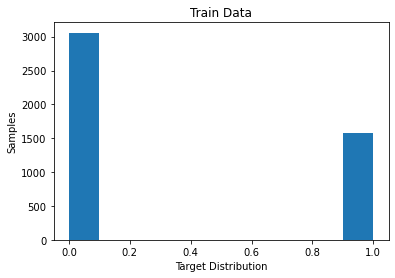

In [12]:
import matplotlib.pyplot as plt
plt.title('Train Data')
plt.xlabel('Target Distribution')
plt.ylabel('Samples')
plt.hist(train_df.label)
plt.show()

In [13]:
combined_df = train_df.append(dev_df, ignore_index = True)
combined_df

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,friends_count,contains_profile_background_image,reputation_score_1,reputation_score_2,favourites_count,verified,geo_enabled,has_description,length_description,label
0,552800070199148544,How to respond to the murderous attack on Char...,228,77,True,False,0,True,27923,185,...,414,True,9.985542,0.908971,500,False,False,True,46,0
1,544388259359387648,"You can not condemn an entire race, nation or ...",352,252,False,False,0,False,745,2,...,222,True,0.704036,0.413158,428,False,False,True,115,0
2,552805970536333314,Attempts to extend blame for this to all Musli...,876,400,False,False,0,False,74137,1431,...,1658,True,21.040989,0.954630,6423,False,True,True,149,0
3,525071376084791297,"Rest in Peace, Cpl. Nathan Cirillo. Killed tod...",112,96,False,True,1,True,28103,418,...,1052,True,14.048433,0.933548,2140,True,True,True,157,1
4,498355319979143168,People DEBATING whether MikeBrown shoplifted o...,802,298,False,False,0,False,55920,65,...,914,True,2.114754,0.678947,25389,False,False,True,156,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,525025279803424768,The soldier shot dead in Wednesday is Ottawa a...,119,36,False,False,0,True,88483,306,...,2454,True,2.663951,0.727071,1903,True,True,True,101,1
5217,552784600502915072,Charlie Hebdo became well known for publishing...,202,41,False,False,0,False,15128,1657,...,2268,True,18.330101,0.948267,0,True,True,True,158,0
5218,499696525808001024,We got through. That is a sniper on top of a t...,432,55,False,True,1,False,61902,1627,...,521,True,54.639847,0.982027,1163,False,True,True,159,0
5219,580320612155060224,Last position of Germanwings flight 4U9525 at ...,3092,480,False,True,1,True,7991,2384,...,369,True,578.891892,0.998276,1131,True,True,True,146,1


In [14]:
len(dev_df)

580

In [15]:
combined_df['text'][0]

"How to respond to the murderous attack on Charlie Hebdo? Every newspaper in the free world should print this. [SEP] Jews label anyone they do not like as Anti-Semite and campaign until that person/company is finished. [SEP] No one does. [SEP] ImCharlieHebdo [SEP] Ditto [SEP] What innocent Muslims ought to find insulting is an atrocity committed in their name, not a sodding cartoon. [SEP] Yes, until it becomes yours. [SEP] Why insult people who have nothing to do with this? People are genuinely offended by such drawings. [SEP] And neither am I! I think this has little to do with actual Muslims. [SEP] Ah, you do not like Jews. Bye bye. [SEP] Also they kid you along with benign stuff then ... WHAM it is like a river of shite! [SEP] It is a good point [SEP] How about this? [SEP] Organised Jewry, I mean, not the actual people. Otherwise I would be hating on my own ancestors. [SEP] ...and this: [SEP] explored. [SEP] And if that is the case, that is your problem. [SEP] No point insulting bil

## Multi-modal BERT

In [16]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """
    model_name_or_path: str = field(
      metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
      default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
      default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
      default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )


@dataclass
class MultimodalDataTrainingArguments:
    """
    Arguments pertaining to how we combine tabular features
    Using `HfArgumentParser` we can turn this class
    into argparse arguments to be able to specify them on
    the command line.
    """

    data_path: str = field(metadata={
                            'help': 'the path to the csv file containing the dataset'
                        })
    column_info_path: str = field(
      default=None,
      metadata={
          'help': 'the path to the json file detailing which columns are text, categorical, numerical, and the label'
    })

    column_info: dict = field(
      default=None,
      metadata={
          'help': 'a dict referencing the text, categorical, numerical, and label columns'
                  'its keys are text_cols, num_cols, cat_cols, and label_col'
    })

    categorical_encode_type: str = field(default='ohe',
                                        metadata={
                                            'help': 'sklearn encoder to use for categorical data',
                                            'choices': ['ohe', 'binary', 'label', 'none']
                                        })
    numerical_transformer_method: str = field(default='yeo_johnson',
                                            metadata={
                                                'help': 'sklearn numerical transformer to preprocess numerical data',
                                                'choices': ['yeo_johnson', 'box_cox', 'quantile_normal', 'none']
                                            })
    task: str = field(default="classification",
                    metadata={
                        "help": "The downstream training task",
                        "choices": ["classification", "regression"]
                    })

    mlp_division: int = field(default=4,
                            metadata={
                                'help': 'the ratio of the number of '
                                        'hidden dims in a current layer to the next MLP layer'
                            })
    combine_feat_method: str = field(default='individual_mlps_on_cat_and_numerical_feats_then_concat',
                                    metadata={
                                        'help': 'method to combine categorical and numerical features, '
                                                'see README for all the method'
                                    })
    mlp_dropout: float = field(default=0.1,
                              metadata={
                                'help': 'dropout ratio used for MLP layers'
                              })
    numerical_bn: bool = field(default=True,
                              metadata={
                                  'help': 'whether to use batchnorm on numerical features'
                              })
    use_simple_classifier: str = field(default=True,
                                      metadata={
                                          'help': 'whether to use single layer or MLP as final classifier'
                                      })
    mlp_act: str = field(default='relu',
                        metadata={
                            'help': 'the activation function to use for finetuning layers',
                            'choices': ['relu', 'prelu', 'sigmoid', 'tanh', 'linear']
                        })
    gating_beta: float = field(default=0.2,
                              metadata={
                                  'help': "the beta hyperparameters used for gating tabular data "
                                          "see https://www.aclweb.org/anthology/2020.acl-main.214.pdf"
                              })

    def __post_init__(self):
        assert self.column_info != self.column_info_path
        if self.column_info is None and self.column_info_path:
            with open(self.column_info_path, 'r') as f:
                self.column_info = json.load(f)

In [33]:
text_cols = ['text']
cat_cols = ['question_mark', 'contains_url', 'contains_media', 'contains_profile_background_image', 'verified', 'geo_enabled', 'has_description']
numerical_cols = ['retweet_count', 'favorite_count', 'number_urls','statuses_count', 'listed_count', 'reputation_score_1', 'reputation_score_2', 'favourites_count','length_description','follow_tweets']

column_info_dict = {
    'text_cols': text_cols,
    'num_cols': numerical_cols,
    'cat_cols': cat_cols,
    'label_col': 'label',
    'label_list': [0, 1]
}


model_args = ModelArguments(
    model_name_or_path='bert-base-uncased'
)

data_args = MultimodalDataTrainingArguments(
    data_path='.',
    combine_feat_method='gating_on_cat_and_num_feats_then_sum',
    column_info=column_info_dict,
    task='classification'
)

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=4,
    num_train_epochs=5,
    evaluate_during_training=True,
    logging_steps=25,
    eval_steps=250,
    dataloader_drop_last=True
)

set_seed(training_args.seed)

In [34]:
tokenizer_path_or_name = model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path
print('Specified tokenizer: ', tokenizer_path_or_name)

# Tokens automatically converted to lower_case
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_path_or_name,
    cache_dir=model_args.cache_dir
)

Specified tokenizer:  bert-base-uncased


In [35]:
# Get Datasets
train_dataset, dev_dataset, test_dataset = load_data_from_folder(train_df, dev_df, test_df,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    label_list=data_args.column_info['label_list'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token
)

INFO:multimodal_transformers.data.data_utils:9 numerical columns
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
INFO:multimodal_transformers.data.data_utils:20 categorical columns
INFO:multimodal_transformers.data.data_utils:9 numerical columns
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
INFO:multimodal_transformers.data.load_data:Text

In [36]:
dev_dataset

In [37]:
num_labels = len(np.unique(train_dataset.labels))
num_labels

2

In [38]:
config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
    )
tabular_config = TabularConfig(num_labels=num_labels,
                               cat_feat_dim=train_dataset.cat_feats.shape[1],
                               numerical_feat_dim=train_dataset.numerical_feats.shape[1],
                               **vars(data_args))
config.tabular_config = tabular_config

In [39]:
model = AutoModelWithTabular.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        config=config,
        cache_dir=model_args.cache_dir
    )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifi

In [40]:
"""
import numpy as np
from scipy.special import softmax
from sklearn.metrics import (
    auc,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
)

def calc_classification_metrics(p: EvalPrediction):
    pred_labels = np.argmax(p.predictions, axis=1)
    pred_scores = softmax(p.predictions, axis=1)[:, 1]
    labels = p.label_ids
    if len(np.unique(labels)) == 2:  # binary classification
        roc_auc_pred_score = roc_auc_score(labels, pred_scores)
        precisions, recalls, thresholds = precision_recall_curve(labels,
                                                                pred_scores)
        fscore = (2 * precisions * recalls) / (precisions + recalls)
        fscore[np.isnan(fscore)] = 0
        ix = np.argmax(fscore)
        threshold = thresholds[ix].item()
        pr_auc = auc(recalls, precisions)
        tn, fp, fn, tp = confusion_matrix(labels, pred_labels, labels=[0, 1]).ravel()
        result = {'roc_auc': roc_auc_pred_score,
                'threshold': threshold,
                'pr_auc': pr_auc,
                'recall': recalls[ix].item(),
                'precision': precisions[ix].item(), 'f1': fscore[ix].item(),
                'tn': tn.item(), 'fp': fp.item(), 'fn': fn.item(), 'tp': tp.item()
                }
    else:
        acc = (pred_labels == labels).mean()
        f1 = f1_score(y_true=labels, y_pred=pred_labels)
        result = {
          "acc": acc,
          "f1": f1,
          "acc_and_f1": (acc + f1) / 2,
          "mcc": matthews_corrcoef(labels, pred_labels)
        }

    return result
"""

'\nimport numpy as np\nfrom scipy.special import softmax\nfrom sklearn.metrics import (\n    auc,\n    precision_recall_curve,\n    roc_auc_score,\n    f1_score,\n    confusion_matrix,\n    matthews_corrcoef,\n)\n\ndef calc_classification_metrics(p: EvalPrediction):\n    pred_labels = np.argmax(p.predictions, axis=1)\n    pred_scores = softmax(p.predictions, axis=1)[:, 1]\n    labels = p.label_ids\n    if len(np.unique(labels)) == 2:  # binary classification\n        roc_auc_pred_score = roc_auc_score(labels, pred_scores)\n        precisions, recalls, thresholds = precision_recall_curve(labels,\n                                                                pred_scores)\n        fscore = (2 * precisions * recalls) / (precisions + recalls)\n        fscore[np.isnan(fscore)] = 0\n        ix = np.argmax(fscore)\n        threshold = thresholds[ix].item()\n        pr_auc = auc(recalls, precisions)\n        tn, fp, fn, tp = confusion_matrix(labels, pred_labels, labels=[0, 1]).ravel()\n      

In [41]:
#import torch
#torch.cuda.empty_cache()

In [42]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)
# compute_metrics=calc_classification_metrics

In [46]:
%%time
trainer.train()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1160 [00:00<?, ?it/s]

{'loss': 0.7320793151855469, 'learning_rate': 4.978448275862069e-05, 'epoch': 0.021551724137931036, 'step': 25}
{'loss': 0.5969670104980469, 'learning_rate': 4.9568965517241384e-05, 'epoch': 0.04310344827586207, 'step': 50}
{'loss': 0.6636334228515625, 'learning_rate': 4.935344827586207e-05, 'epoch': 0.06465517241379311, 'step': 75}
{'loss': 0.5826614379882813, 'learning_rate': 4.913793103448276e-05, 'epoch': 0.08620689655172414, 'step': 100}
{'loss': 0.6537063598632813, 'learning_rate': 4.892241379310345e-05, 'epoch': 0.10775862068965517, 'step': 125}
{'loss': 0.6578781127929687, 'learning_rate': 4.870689655172414e-05, 'epoch': 0.12931034482758622, 'step': 150}
{'loss': 0.6459063720703125, 'learning_rate': 4.849137931034483e-05, 'epoch': 0.15086206896551724, 'step': 175}
{'loss': 0.5088858032226562, 'learning_rate': 4.827586206896552e-05, 'epoch': 0.1724137931034483, 'step': 200}
{'loss': 0.6277755737304688, 'learning_rate': 4.806034482758621e-05, 'epoch': 0.1939655172413793, 'step': 

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5281306765973568, 'epoch': 0.21551724137931033, 'step': 250}
{'loss': 0.597335205078125, 'learning_rate': 4.762931034482759e-05, 'epoch': 0.23706896551724138, 'step': 275}
{'loss': 0.4887872314453125, 'learning_rate': 4.741379310344828e-05, 'epoch': 0.25862068965517243, 'step': 300}
{'loss': 0.59904296875, 'learning_rate': 4.719827586206897e-05, 'epoch': 0.2801724137931034, 'step': 325}
{'loss': 0.4641412353515625, 'learning_rate': 4.698275862068966e-05, 'epoch': 0.3017241379310345, 'step': 350}
{'loss': 0.6923199462890625, 'learning_rate': 4.6767241379310346e-05, 'epoch': 0.3232758620689655, 'step': 375}
{'loss': 0.578714599609375, 'learning_rate': 4.655172413793104e-05, 'epoch': 0.3448275862068966, 'step': 400}
{'loss': 0.576748046875, 'learning_rate': 4.633620689655173e-05, 'epoch': 0.36637931034482757, 'step': 425}
{'loss': 0.649656982421875, 'learning_rate': 4.612068965517242e-05, 'epoch': 0.3879310344827586, 'step': 450}
{'loss': 0.518597412109375, 'learning_rate'

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5121819867442051, 'epoch': 0.43103448275862066, 'step': 500}
{'loss': 0.58185302734375, 'learning_rate': 4.5474137931034485e-05, 'epoch': 0.4525862068965517, 'step': 525}
{'loss': 0.4774560546875, 'learning_rate': 4.5258620689655176e-05, 'epoch': 0.47413793103448276, 'step': 550}
{'loss': 0.564193115234375, 'learning_rate': 4.504310344827587e-05, 'epoch': 0.4956896551724138, 'step': 575}
{'loss': 0.62172119140625, 'learning_rate': 4.482758620689655e-05, 'epoch': 0.5172413793103449, 'step': 600}
{'loss': 0.639105224609375, 'learning_rate': 4.461206896551724e-05, 'epoch': 0.5387931034482759, 'step': 625}
{'loss': 0.565242919921875, 'learning_rate': 4.4396551724137933e-05, 'epoch': 0.5603448275862069, 'step': 650}
{'loss': 0.52958984375, 'learning_rate': 4.418103448275862e-05, 'epoch': 0.5818965517241379, 'step': 675}
{'loss': 0.59009033203125, 'learning_rate': 4.396551724137931e-05, 'epoch': 0.603448275862069, 'step': 700}
{'loss': 0.571090087890625, 'learning_rate': 4.37

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5075280379710926, 'epoch': 0.646551724137931, 'step': 750}
{'loss': 0.6191552734375, 'learning_rate': 4.331896551724138e-05, 'epoch': 0.6681034482758621, 'step': 775}
{'loss': 0.645965576171875, 'learning_rate': 4.3103448275862066e-05, 'epoch': 0.6896551724137931, 'step': 800}
{'loss': 0.52297607421875, 'learning_rate': 4.288793103448276e-05, 'epoch': 0.7112068965517241, 'step': 825}
{'loss': 0.60324951171875, 'learning_rate': 4.267241379310345e-05, 'epoch': 0.7327586206896551, 'step': 850}
{'loss': 0.535001220703125, 'learning_rate': 4.245689655172414e-05, 'epoch': 0.7543103448275862, 'step': 875}
{'loss': 0.5755078125, 'learning_rate': 4.224137931034483e-05, 'epoch': 0.7758620689655172, 'step': 900}
{'loss': 0.539013671875, 'learning_rate': 4.202586206896552e-05, 'epoch': 0.7974137931034483, 'step': 925}
{'loss': 0.64329345703125, 'learning_rate': 4.1810344827586205e-05, 'epoch': 0.8189655172413793, 'step': 950}
{'loss': 0.57313720703125, 'learning_rate': 4.1594827586

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.48247574600908494, 'epoch': 0.8620689655172413, 'step': 1000}
{'loss': 0.56531005859375, 'learning_rate': 4.116379310344828e-05, 'epoch': 0.8836206896551724, 'step': 1025}
{'loss': 0.51462890625, 'learning_rate': 4.094827586206897e-05, 'epoch': 0.9051724137931034, 'step': 1050}
{'loss': 0.56205322265625, 'learning_rate': 4.073275862068966e-05, 'epoch': 0.9267241379310345, 'step': 1075}
{'loss': 0.5455615234375, 'learning_rate': 4.0517241379310344e-05, 'epoch': 0.9482758620689655, 'step': 1100}
{'loss': 0.4671484375, 'learning_rate': 4.0301724137931035e-05, 'epoch': 0.9698275862068966, 'step': 1125}
{'loss': 0.51127197265625, 'learning_rate': 4.0086206896551726e-05, 'epoch': 0.9913793103448276, 'step': 1150}


Iteration:   0%|          | 0/1160 [00:00<?, ?it/s]

{'loss': 0.58487548828125, 'learning_rate': 3.9870689655172416e-05, 'epoch': 1.0129310344827587, 'step': 1175}
{'loss': 0.52560546875, 'learning_rate': 3.965517241379311e-05, 'epoch': 1.0344827586206897, 'step': 1200}
{'loss': 0.29550048828125, 'learning_rate': 3.94396551724138e-05, 'epoch': 1.0560344827586208, 'step': 1225}
{'loss': 0.7842626953125, 'learning_rate': 3.922413793103448e-05, 'epoch': 1.0775862068965518, 'step': 1250}


Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5576875511970785, 'epoch': 1.0775862068965518, 'step': 1250}
{'loss': 0.62856201171875, 'learning_rate': 3.9008620689655174e-05, 'epoch': 1.0991379310344827, 'step': 1275}
{'loss': 0.5961572265625, 'learning_rate': 3.8793103448275865e-05, 'epoch': 1.1206896551724137, 'step': 1300}
{'loss': 0.59150146484375, 'learning_rate': 3.8577586206896555e-05, 'epoch': 1.1422413793103448, 'step': 1325}
{'loss': 0.610654296875, 'learning_rate': 3.8362068965517246e-05, 'epoch': 1.1637931034482758, 'step': 1350}
{'loss': 0.51314697265625, 'learning_rate': 3.814655172413794e-05, 'epoch': 1.1853448275862069, 'step': 1375}
{'loss': 0.626650390625, 'learning_rate': 3.793103448275862e-05, 'epoch': 1.206896551724138, 'step': 1400}
{'loss': 0.539677734375, 'learning_rate': 3.771551724137931e-05, 'epoch': 1.228448275862069, 'step': 1425}
{'loss': 0.61462158203125, 'learning_rate': 3.7500000000000003e-05, 'epoch': 1.25, 'step': 1450}
{'loss': 0.5386083984375, 'learning_rate': 3.7284482758620694

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5239744612740146, 'epoch': 1.293103448275862, 'step': 1500}
{'loss': 0.68726318359375, 'learning_rate': 3.685344827586207e-05, 'epoch': 1.3146551724137931, 'step': 1525}
{'loss': 0.6437158203125, 'learning_rate': 3.663793103448276e-05, 'epoch': 1.3362068965517242, 'step': 1550}
{'loss': 0.5522216796875, 'learning_rate': 3.642241379310345e-05, 'epoch': 1.3577586206896552, 'step': 1575}
{'loss': 0.66591552734375, 'learning_rate': 3.620689655172414e-05, 'epoch': 1.3793103448275863, 'step': 1600}
{'loss': 0.657119140625, 'learning_rate': 3.5991379310344833e-05, 'epoch': 1.4008620689655173, 'step': 1625}
{'loss': 0.63150634765625, 'learning_rate': 3.5775862068965524e-05, 'epoch': 1.4224137931034484, 'step': 1650}
{'loss': 0.579462890625, 'learning_rate': 3.556034482758621e-05, 'epoch': 1.4439655172413794, 'step': 1675}
{'loss': 0.5960107421875, 'learning_rate': 3.53448275862069e-05, 'epoch': 1.4655172413793103, 'step': 1700}
{'loss': 0.4897314453125, 'learning_rate': 3.51293

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5312832509064012, 'epoch': 1.5086206896551724, 'step': 1750}
{'loss': 0.71786865234375, 'learning_rate': 3.4698275862068966e-05, 'epoch': 1.5301724137931034, 'step': 1775}
{'loss': 0.581982421875, 'learning_rate': 3.4482758620689657e-05, 'epoch': 1.5517241379310345, 'step': 1800}
{'loss': 0.564033203125, 'learning_rate': 3.426724137931035e-05, 'epoch': 1.5732758620689655, 'step': 1825}
{'loss': 0.544189453125, 'learning_rate': 3.405172413793103e-05, 'epoch': 1.5948275862068966, 'step': 1850}
{'loss': 0.60484375, 'learning_rate': 3.383620689655172e-05, 'epoch': 1.6163793103448276, 'step': 1875}
{'loss': 0.6485302734375, 'learning_rate': 3.3620689655172414e-05, 'epoch': 1.6379310344827587, 'step': 1900}
{'loss': 0.5492724609375, 'learning_rate': 3.3405172413793105e-05, 'epoch': 1.6594827586206895, 'step': 1925}
{'loss': 0.5917431640625, 'learning_rate': 3.3189655172413796e-05, 'epoch': 1.6810344827586206, 'step': 1950}
{'loss': 0.5191796875, 'learning_rate': 3.29741379310

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5020458876258798, 'epoch': 1.7241379310344827, 'step': 2000}
{'loss': 0.6525146484375, 'learning_rate': 3.254310344827586e-05, 'epoch': 1.7456896551724137, 'step': 2025}
{'loss': 0.556259765625, 'learning_rate': 3.232758620689655e-05, 'epoch': 1.7672413793103448, 'step': 2050}
{'loss': 0.565078125, 'learning_rate': 3.2112068965517244e-05, 'epoch': 1.7887931034482758, 'step': 2075}
{'loss': 0.4760791015625, 'learning_rate': 3.1896551724137935e-05, 'epoch': 1.8103448275862069, 'step': 2100}
{'loss': 0.5473779296875, 'learning_rate': 3.168103448275862e-05, 'epoch': 1.831896551724138, 'step': 2125}
{'loss': 0.50130859375, 'learning_rate': 3.146551724137931e-05, 'epoch': 1.853448275862069, 'step': 2150}
{'loss': 0.61603515625, 'learning_rate': 3.125e-05, 'epoch': 1.875, 'step': 2175}
{'loss': 0.496689453125, 'learning_rate': 3.103448275862069e-05, 'epoch': 1.896551724137931, 'step': 2200}
{'loss': 0.5495654296875, 'learning_rate': 3.081896551724138e-05, 'epoch': 1.9181034482

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.47532775273753536, 'epoch': 1.9396551724137931, 'step': 2250}
{'loss': 0.509580078125, 'learning_rate': 3.0387931034482758e-05, 'epoch': 1.9612068965517242, 'step': 2275}
{'loss': 0.54958984375, 'learning_rate': 3.017241379310345e-05, 'epoch': 1.9827586206896552, 'step': 2300}


Iteration:   0%|          | 0/1160 [00:00<?, ?it/s]

{'loss': 0.5353515625, 'learning_rate': 2.995689655172414e-05, 'epoch': 2.0043103448275863, 'step': 2325}
{'loss': 0.4999853515625, 'learning_rate': 2.974137931034483e-05, 'epoch': 2.0258620689655173, 'step': 2350}
{'loss': 0.4860400390625, 'learning_rate': 2.952586206896552e-05, 'epoch': 2.0474137931034484, 'step': 2375}
{'loss': 0.456337890625, 'learning_rate': 2.9310344827586206e-05, 'epoch': 2.0689655172413794, 'step': 2400}
{'loss': 0.6574365234375, 'learning_rate': 2.9094827586206897e-05, 'epoch': 2.0905172413793105, 'step': 2425}
{'loss': 0.464921875, 'learning_rate': 2.8879310344827588e-05, 'epoch': 2.1120689655172415, 'step': 2450}
{'loss': 0.501455078125, 'learning_rate': 2.866379310344828e-05, 'epoch': 2.1336206896551726, 'step': 2475}
{'loss': 0.5910595703125, 'learning_rate': 2.844827586206897e-05, 'epoch': 2.1551724137931036, 'step': 2500}


Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.44759229612019324, 'epoch': 2.1551724137931036, 'step': 2500}
{'loss': 0.491298828125, 'learning_rate': 2.8232758620689657e-05, 'epoch': 2.1767241379310347, 'step': 2525}
{'loss': 0.5008251953125, 'learning_rate': 2.8017241379310345e-05, 'epoch': 2.1982758620689653, 'step': 2550}
{'loss': 0.548173828125, 'learning_rate': 2.7801724137931036e-05, 'epoch': 2.2198275862068964, 'step': 2575}
{'loss': 0.4869287109375, 'learning_rate': 2.7586206896551727e-05, 'epoch': 2.2413793103448274, 'step': 2600}
{'loss': 0.360908203125, 'learning_rate': 2.7370689655172414e-05, 'epoch': 2.2629310344827585, 'step': 2625}
{'loss': 0.6636328125, 'learning_rate': 2.7155172413793105e-05, 'epoch': 2.2844827586206895, 'step': 2650}
{'loss': 0.4993798828125, 'learning_rate': 2.6939655172413796e-05, 'epoch': 2.3060344827586206, 'step': 2675}
{'loss': 0.4690185546875, 'learning_rate': 2.672413793103448e-05, 'epoch': 2.3275862068965516, 'step': 2700}
{'loss': 0.622451171875, 'learning_rate': 2.65086

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.45269018991125953, 'epoch': 2.3706896551724137, 'step': 2750}
{'loss': 0.55255859375, 'learning_rate': 2.6077586206896553e-05, 'epoch': 2.3922413793103448, 'step': 2775}
{'loss': 0.5743994140625, 'learning_rate': 2.5862068965517244e-05, 'epoch': 2.413793103448276, 'step': 2800}
{'loss': 0.5100048828125, 'learning_rate': 2.5646551724137935e-05, 'epoch': 2.435344827586207, 'step': 2825}
{'loss': 0.6708447265625, 'learning_rate': 2.543103448275862e-05, 'epoch': 2.456896551724138, 'step': 2850}
{'loss': 0.5584814453125, 'learning_rate': 2.521551724137931e-05, 'epoch': 2.478448275862069, 'step': 2875}
{'loss': 0.5103515625, 'learning_rate': 2.5e-05, 'epoch': 2.5, 'step': 2900}
{'loss': 0.603173828125, 'learning_rate': 2.4784482758620692e-05, 'epoch': 2.521551724137931, 'step': 2925}
{'loss': 0.608603515625, 'learning_rate': 2.456896551724138e-05, 'epoch': 2.543103448275862, 'step': 2950}
{'loss': 0.6482666015625, 'learning_rate': 2.435344827586207e-05, 'epoch': 2.56465517241

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.6472418492452966, 'epoch': 2.586206896551724, 'step': 3000}
{'loss': 0.61701171875, 'learning_rate': 2.392241379310345e-05, 'epoch': 2.6077586206896552, 'step': 3025}
{'loss': 0.551064453125, 'learning_rate': 2.370689655172414e-05, 'epoch': 2.6293103448275863, 'step': 3050}
{'loss': 0.4997412109375, 'learning_rate': 2.349137931034483e-05, 'epoch': 2.6508620689655173, 'step': 3075}
{'loss': 0.5933740234375, 'learning_rate': 2.327586206896552e-05, 'epoch': 2.6724137931034484, 'step': 3100}
{'loss': 0.6162548828125, 'learning_rate': 2.306034482758621e-05, 'epoch': 2.6939655172413794, 'step': 3125}
{'loss': 0.3707861328125, 'learning_rate': 2.2844827586206897e-05, 'epoch': 2.7155172413793105, 'step': 3150}
{'loss': 0.518056640625, 'learning_rate': 2.2629310344827588e-05, 'epoch': 2.737068965517241, 'step': 3175}
{'loss': 0.603583984375, 'learning_rate': 2.2413793103448276e-05, 'epoch': 2.7586206896551726, 'step': 3200}
{'loss': 0.56357421875, 'learning_rate': 2.219827586206

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.4793462680859698, 'epoch': 2.8017241379310347, 'step': 3250}
{'loss': 0.6689453125, 'learning_rate': 2.1767241379310345e-05, 'epoch': 2.8232758620689653, 'step': 3275}
{'loss': 0.5510302734375, 'learning_rate': 2.1551724137931033e-05, 'epoch': 2.844827586206897, 'step': 3300}
{'loss': 0.52771484375, 'learning_rate': 2.1336206896551724e-05, 'epoch': 2.8663793103448274, 'step': 3325}
{'loss': 0.68904296875, 'learning_rate': 2.1120689655172415e-05, 'epoch': 2.887931034482759, 'step': 3350}
{'loss': 0.582275390625, 'learning_rate': 2.0905172413793102e-05, 'epoch': 2.9094827586206895, 'step': 3375}
{'loss': 0.5940087890625, 'learning_rate': 2.0689655172413793e-05, 'epoch': 2.9310344827586206, 'step': 3400}
{'loss': 0.484794921875, 'learning_rate': 2.0474137931034484e-05, 'epoch': 2.9525862068965516, 'step': 3425}
{'loss': 0.459453125, 'learning_rate': 2.0258620689655172e-05, 'epoch': 2.9741379310344827, 'step': 3450}
{'loss': 0.437265625, 'learning_rate': 2.0043103448275863e

Iteration:   0%|          | 0/1160 [00:00<?, ?it/s]

{'loss': 0.4273193359375, 'learning_rate': 1.9827586206896554e-05, 'epoch': 3.0172413793103448, 'step': 3500}


Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5591199244889948, 'epoch': 3.0172413793103448, 'step': 3500}
{'loss': 0.5425927734375, 'learning_rate': 1.961206896551724e-05, 'epoch': 3.038793103448276, 'step': 3525}
{'loss': 0.5, 'learning_rate': 1.9396551724137932e-05, 'epoch': 3.060344827586207, 'step': 3550}
{'loss': 0.5054296875, 'learning_rate': 1.9181034482758623e-05, 'epoch': 3.081896551724138, 'step': 3575}
{'loss': 0.5446826171875, 'learning_rate': 1.896551724137931e-05, 'epoch': 3.103448275862069, 'step': 3600}
{'loss': 0.4680078125, 'learning_rate': 1.8750000000000002e-05, 'epoch': 3.125, 'step': 3625}
{'loss': 0.5540234375, 'learning_rate': 1.8534482758620693e-05, 'epoch': 3.146551724137931, 'step': 3650}
{'loss': 0.62345703125, 'learning_rate': 1.831896551724138e-05, 'epoch': 3.168103448275862, 'step': 3675}
{'loss': 0.595458984375, 'learning_rate': 1.810344827586207e-05, 'epoch': 3.189655172413793, 'step': 3700}
{'loss': 0.48359375, 'learning_rate': 1.7887931034482762e-05, 'epoch': 3.211206896551724, '

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.4815957127656374, 'epoch': 3.2327586206896552, 'step': 3750}
{'loss': 0.55970703125, 'learning_rate': 1.7456896551724137e-05, 'epoch': 3.2543103448275863, 'step': 3775}
{'loss': 0.7755859375, 'learning_rate': 1.7241379310344828e-05, 'epoch': 3.2758620689655173, 'step': 3800}
{'loss': 0.503994140625, 'learning_rate': 1.7025862068965516e-05, 'epoch': 3.2974137931034484, 'step': 3825}
{'loss': 0.50763671875, 'learning_rate': 1.6810344827586207e-05, 'epoch': 3.3189655172413794, 'step': 3850}
{'loss': 0.576923828125, 'learning_rate': 1.6594827586206898e-05, 'epoch': 3.3405172413793105, 'step': 3875}
{'loss': 0.470703125, 'learning_rate': 1.6379310344827585e-05, 'epoch': 3.3620689655172415, 'step': 3900}
{'loss': 0.547939453125, 'learning_rate': 1.6163793103448276e-05, 'epoch': 3.3836206896551726, 'step': 3925}
{'loss': 0.5341796875, 'learning_rate': 1.5948275862068967e-05, 'epoch': 3.405172413793103, 'step': 3950}
{'loss': 0.512431640625, 'learning_rate': 1.5732758620689655e

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.43435351628189284, 'epoch': 3.4482758620689653, 'step': 4000}
{'loss': 0.466962890625, 'learning_rate': 1.5301724137931033e-05, 'epoch': 3.469827586206897, 'step': 4025}
{'loss': 0.657919921875, 'learning_rate': 1.5086206896551724e-05, 'epoch': 3.4913793103448274, 'step': 4050}
{'loss': 0.5426171875, 'learning_rate': 1.4870689655172415e-05, 'epoch': 3.512931034482759, 'step': 4075}
{'loss': 0.479755859375, 'learning_rate': 1.4655172413793103e-05, 'epoch': 3.5344827586206895, 'step': 4100}
{'loss': 0.452119140625, 'learning_rate': 1.4439655172413794e-05, 'epoch': 3.5560344827586206, 'step': 4125}
{'loss': 0.63109375, 'learning_rate': 1.4224137931034485e-05, 'epoch': 3.5775862068965516, 'step': 4150}
{'loss': 0.688544921875, 'learning_rate': 1.4008620689655172e-05, 'epoch': 3.5991379310344827, 'step': 4175}
{'loss': 0.47623046875, 'learning_rate': 1.3793103448275863e-05, 'epoch': 3.6206896551724137, 'step': 4200}
{'loss': 0.53892578125, 'learning_rate': 1.3577586206896553

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.4764930248363978, 'epoch': 3.663793103448276, 'step': 4250}
{'loss': 0.428408203125, 'learning_rate': 1.3146551724137931e-05, 'epoch': 3.685344827586207, 'step': 4275}
{'loss': 0.634951171875, 'learning_rate': 1.2931034482758622e-05, 'epoch': 3.706896551724138, 'step': 4300}
{'loss': 0.449638671875, 'learning_rate': 1.271551724137931e-05, 'epoch': 3.728448275862069, 'step': 4325}
{'loss': 0.491064453125, 'learning_rate': 1.25e-05, 'epoch': 3.75, 'step': 4350}
{'loss': 0.76146484375, 'learning_rate': 1.228448275862069e-05, 'epoch': 3.771551724137931, 'step': 4375}
{'loss': 0.399755859375, 'learning_rate': 1.206896551724138e-05, 'epoch': 3.793103448275862, 'step': 4400}
{'loss': 0.385244140625, 'learning_rate': 1.185344827586207e-05, 'epoch': 3.814655172413793, 'step': 4425}
{'loss': 0.5253515625, 'learning_rate': 1.163793103448276e-05, 'epoch': 3.836206896551724, 'step': 4450}
{'loss': 0.42771484375, 'learning_rate': 1.1422413793103449e-05, 'epoch': 3.8577586206896552, '

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.43928039733630914, 'epoch': 3.8793103448275863, 'step': 4500}
{'loss': 0.53544921875, 'learning_rate': 1.0991379310344827e-05, 'epoch': 3.9008620689655173, 'step': 4525}
{'loss': 0.54662109375, 'learning_rate': 1.0775862068965516e-05, 'epoch': 3.9224137931034484, 'step': 4550}
{'loss': 0.463017578125, 'learning_rate': 1.0560344827586207e-05, 'epoch': 3.9439655172413794, 'step': 4575}
{'loss': 0.50830078125, 'learning_rate': 1.0344827586206897e-05, 'epoch': 3.9655172413793105, 'step': 4600}
{'loss': 0.6694921875, 'learning_rate': 1.0129310344827586e-05, 'epoch': 3.987068965517241, 'step': 4625}


Iteration:   0%|          | 0/1160 [00:00<?, ?it/s]

{'loss': 0.583837890625, 'learning_rate': 9.913793103448277e-06, 'epoch': 4.008620689655173, 'step': 4650}
{'loss': 0.4606640625, 'learning_rate': 9.698275862068966e-06, 'epoch': 4.030172413793103, 'step': 4675}
{'loss': 0.46861328125, 'learning_rate': 9.482758620689655e-06, 'epoch': 4.051724137931035, 'step': 4700}
{'loss': 0.638701171875, 'learning_rate': 9.267241379310346e-06, 'epoch': 4.073275862068965, 'step': 4725}
{'loss': 0.7244140625, 'learning_rate': 9.051724137931036e-06, 'epoch': 4.094827586206897, 'step': 4750}


Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.4364030525709192, 'epoch': 4.094827586206897, 'step': 4750}
{'loss': 0.54802734375, 'learning_rate': 8.836206896551725e-06, 'epoch': 4.116379310344827, 'step': 4775}
{'loss': 0.487646484375, 'learning_rate': 8.620689655172414e-06, 'epoch': 4.137931034482759, 'step': 4800}
{'loss': 0.61646484375, 'learning_rate': 8.405172413793103e-06, 'epoch': 4.1594827586206895, 'step': 4825}
{'loss': 0.59296875, 'learning_rate': 8.189655172413793e-06, 'epoch': 4.181034482758621, 'step': 4850}
{'loss': 0.311748046875, 'learning_rate': 7.974137931034484e-06, 'epoch': 4.202586206896552, 'step': 4875}
{'loss': 0.707646484375, 'learning_rate': 7.758620689655173e-06, 'epoch': 4.224137931034483, 'step': 4900}
{'loss': 0.496865234375, 'learning_rate': 7.543103448275862e-06, 'epoch': 4.245689655172414, 'step': 4925}
{'loss': 0.44736328125, 'learning_rate': 7.3275862068965514e-06, 'epoch': 4.267241379310345, 'step': 4950}
{'loss': 0.505029296875, 'learning_rate': 7.112068965517242e-06, 'epoch':

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.49047320473214817, 'epoch': 4.310344827586207, 'step': 5000}
{'loss': 0.863759765625, 'learning_rate': 6.68103448275862e-06, 'epoch': 4.331896551724138, 'step': 5025}
{'loss': 0.640810546875, 'learning_rate': 6.465517241379311e-06, 'epoch': 4.353448275862069, 'step': 5050}
{'loss': 0.305732421875, 'learning_rate': 6.25e-06, 'epoch': 4.375, 'step': 5075}
{'loss': 0.478720703125, 'learning_rate': 6.03448275862069e-06, 'epoch': 4.396551724137931, 'step': 5100}
{'loss': 0.488349609375, 'learning_rate': 5.81896551724138e-06, 'epoch': 4.418103448275862, 'step': 5125}
{'loss': 0.508720703125, 'learning_rate': 5.603448275862069e-06, 'epoch': 4.439655172413793, 'step': 5150}
{'loss': 0.63107421875, 'learning_rate': 5.387931034482758e-06, 'epoch': 4.461206896551724, 'step': 5175}
{'loss': 0.70166015625, 'learning_rate': 5.172413793103448e-06, 'epoch': 4.482758620689655, 'step': 5200}
{'loss': 0.29697265625, 'learning_rate': 4.9568965517241384e-06, 'epoch': 4.504310344827586, 'ste

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.49690183389207554, 'epoch': 4.525862068965517, 'step': 5250}
{'loss': 0.583798828125, 'learning_rate': 4.525862068965518e-06, 'epoch': 4.547413793103448, 'step': 5275}
{'loss': 0.61646484375, 'learning_rate': 4.310344827586207e-06, 'epoch': 4.568965517241379, 'step': 5300}
{'loss': 0.4957421875, 'learning_rate': 4.094827586206896e-06, 'epoch': 4.5905172413793105, 'step': 5325}
{'loss': 0.41404296875, 'learning_rate': 3.8793103448275865e-06, 'epoch': 4.612068965517241, 'step': 5350}
{'loss': 0.525673828125, 'learning_rate': 3.6637931034482757e-06, 'epoch': 4.633620689655173, 'step': 5375}
{'loss': 0.661904296875, 'learning_rate': 3.448275862068966e-06, 'epoch': 4.655172413793103, 'step': 5400}
{'loss': 0.564541015625, 'learning_rate': 3.2327586206896555e-06, 'epoch': 4.676724137931035, 'step': 5425}
{'loss': 0.3682421875, 'learning_rate': 3.017241379310345e-06, 'epoch': 4.698275862068965, 'step': 5450}
{'loss': 0.38345703125, 'learning_rate': 2.8017241379310345e-06, 'epo

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5417056862627052, 'epoch': 4.741379310344827, 'step': 5500}
{'loss': 0.583154296875, 'learning_rate': 2.370689655172414e-06, 'epoch': 4.762931034482759, 'step': 5525}
{'loss': 0.601728515625, 'learning_rate': 2.1551724137931035e-06, 'epoch': 4.7844827586206895, 'step': 5550}
{'loss': 0.626494140625, 'learning_rate': 1.9396551724137932e-06, 'epoch': 4.806034482758621, 'step': 5575}
{'loss': 0.5257421875, 'learning_rate': 1.724137931034483e-06, 'epoch': 4.827586206896552, 'step': 5600}
{'loss': 0.5566796875, 'learning_rate': 1.5086206896551726e-06, 'epoch': 4.849137931034483, 'step': 5625}
{'loss': 0.55205078125, 'learning_rate': 1.293103448275862e-06, 'epoch': 4.870689655172414, 'step': 5650}
{'loss': 0.70755859375, 'learning_rate': 1.0775862068965518e-06, 'epoch': 4.892241379310345, 'step': 5675}
{'loss': 0.53328125, 'learning_rate': 8.620689655172415e-07, 'epoch': 4.913793103448276, 'step': 5700}
{'loss': 0.609248046875, 'learning_rate': 6.46551724137931e-07, 'epoch': 

Evaluation:   0%|          | 0/72 [00:00<?, ?it/s]

{'eval_loss': 0.5022836247614274, 'epoch': 4.956896551724138, 'step': 5750}
{'loss': 0.537470703125, 'learning_rate': 2.1551724137931036e-07, 'epoch': 4.978448275862069, 'step': 5775}
{'loss': 0.638212890625, 'learning_rate': 0.0, 'epoch': 5.0, 'step': 5800}
CPU times: user 1h 11min 32s, sys: 23min 29s, total: 1h 35min 2s
Wall time: 1h 35min


TrainOutput(global_step=5800, training_loss=0.5549590433054957)

In [43]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [44]:
%tensorboard --logdir ./logs/runs

Reusing TensorBoard on port 6006 (pid 4644), started 0:01:13 ago. (Use '!kill 4644' to kill it.)

In [60]:
len(test_dataset)

581

In [65]:
trainer.save_model("./multimodal_bert/multimodal_bert_v8")

### Inference

In [69]:
# Need to reload trainer because drop_last = True was set during training.
pred_trained = Trainer(
    model=model
)

In [67]:
result = pred_trained.predict(test_dataset=test_dataset).predictions

Prediction:   0%|          | 0/73 [00:00<?, ?it/s]

In [68]:
len(result)

581

In [70]:
result

array([[-0.73183644,  0.86781955],
       [-1.7730815 ,  1.3484974 ],
       [-1.2793902 ,  1.0951074 ],
       ...,
       [-1.7770942 ,  1.3777128 ],
       [ 1.3113612 , -2.4507856 ],
       [ 1.5208449 , -2.6579978 ]], dtype=float32)

In [71]:
from scipy.special import softmax

pred_labels = np.argmax(result, axis=1)
pred_scores = softmax(result, axis=1)[:, 1]

In [72]:
pred_labels

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [73]:
predicted_labels = [convert_prediction(pred) for pred in pred_labels]

In [74]:
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

,id,target
0,544382249178001408,rumour
1,525027317551079424,rumour
2,544273220128739329,rumour
3,499571799764770816,non-rumour
4,552844104418091008,non-rumour
...,...,...
576,553581227165642752,non-rumour
577,552816302780579840,non-rumour
578,580350000074457088,rumour
579,498584409055174656,non-rumour


In [75]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output.json', 'w') as f:
    json.dump(submission, f)

## Text-only BERT

## Loading BertTokenizer

Load tokenizer based on wordpiece approach

In [16]:
# TODO: Check whether transformerss is allowed
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [17]:
import numpy as np
import tensorflow as tf 

## BERT encoding

Data is encoded according to BERT requirement.There is a very helpful function called encode_plus provided in the Tokenizer class. It can seamlessly perform the following operations:

Tokenize the text
Add special tokens - [CLS] and [SEP]

Add special tokens - [CLS] and [SEP]

create token IDs

Pad the sentences to a common length

Create attention masks for the above PAD tokens

In [18]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []


    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation = True

        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Input are 2 Numpy array. Let me briefly go over them:

1) input_ids : list of token ids to be fed to a model

2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

Note : Token Ids are not necessary as it is used Two Sentence Problem (To differentiate two sentence)

In [19]:
combined_input_ids,combined_attention_masks = bert_encode(combined_df,512)
test_input_ids,test_attention_masks = bert_encode(test_df,512)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
combined_input_ids

array([[  101,  2129,  2000, ...,     0,     0,     0],
       [  101,  2017,  2064, ...,  7499,  1012,   102],
       [  101,  4740,  2000, ...,     0,     0,     0],
       ...,
       [  101,  2057,  2288, ...,  3808,  2034,   102],
       [  101,  2197,  2597, ...,  7471,  3177,   102],
       [  101, 13970, 12269, ...,     0,     0,     0]])

In [21]:
len(combined_input_ids)

5221

## Creating Custom Model

Base TFBert Model with Dense layer and sigmoid activation as head.

In [22]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(512,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(512,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

## TFBertModel

The bare Bert Model transformer outputing raw hidden-states without any specific head on top. https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel

In [23]:
import torch
torch.cuda.empty_cache()

In [24]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Implementing custom model

In [25]:
model = create_model(bert_model)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 1024),  335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]   

## Training

Fit for **5 epochs**:

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
history = model.fit([combined_input_ids,combined_attention_masks],combined_df.label,validation_split=0.1,callbacks=[callback], epochs=5,batch_size=2)

Epoch 1/5
 180/2349 [=>............................] - ETA: 56:27 - loss: 0.7065 - accuracy: 0.5806 - precision: 0.4071 - recall: 0.3538

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [ ]:
model.save("./pure_bert/pure_bert_v10")

## Testing

In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)

In [ ]:
predicted_labels = [convert_prediction(pred) for pred in result]

In [ ]:
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

In [ ]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output.json', 'w') as f:
    json.dump(submission, f)